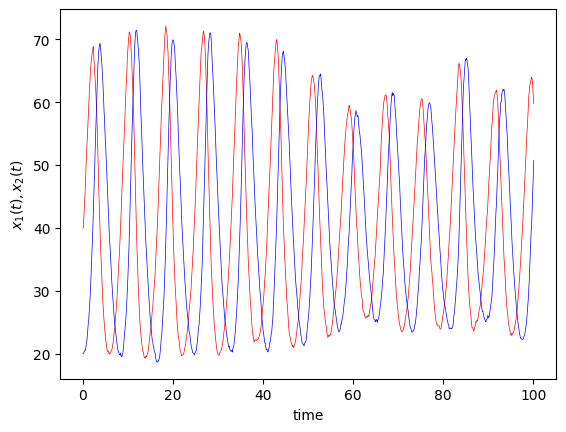

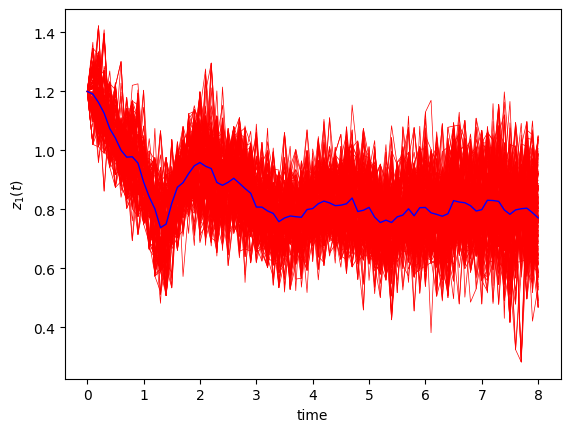

In [1]:
'''
  第8章: 粒子フィルタ
  - Lotka-Volterra系
  - 図8.7のようなものを描画できる
  - 実行に少し時間がかかる（数分程度を見込んでおくとよい）
'''
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# パラメータの設定
D = 2 # 変数の数（次元）
num_event = 3 # イベントの数
Omega = 100.0
c = [0.8, 0.02, 0.8]

# 状態に依存する関数(propensity functioin)の設定
gamma_r = [lambda n: c[0]*n[0],
             lambda n: c[1]*n[0]*n[1],
             lambda n: c[2]*n[1]]
# 各イベントでの状態遷移の設定
v_e = np.array([[+1, 0],
                 [-1,+1],
                 [ 0,-1]])

# 乱数の種の設定
rng = np.random.default_rng(41736)

# シミュレーションの設定
x_ini = [40, 20] # 量の初期値
Dt = 1.0e-3 # オイラー - 丸山法でのΔt
Dt_obs = 1.0e-1 # プロットのための時間間隔
T = 100.0 # 終了時刻

# -------------------------------- 学習データ生成パート
time_array = np.arange(0, T+Dt, Dt)
obs_time_array = np.arange(0, T+2*Dt_obs, Dt_obs)
x = x_ini
dW = rng.standard_normal(size=(len(time_array)-1, num_event))
obs_t = 0.0
result = []
result.append(x)
for i, t in enumerate(time_array[:-1]):
    drift = 0.0
    diff = 0.0
    for r, gamma in enumerate(gamma_r):
        comp = gamma(x)
        drift = drift + v_e[r] * comp * Dt
        diff = diff + v_e[r] * np.sqrt(comp*Dt/Omega) * dW[i][r]
    x = x + drift + diff
    # Lotka-Volterra系では状態は負にはならないことの処理
    if x[0] < 0.0:
        x[0] = 0.0
    if x[1] < 0.0:
        x[1] = 0.0
    # プロットのための保存
    if t+Dt >= (obs_t-1.0e-6):
        obs_t = obs_t + Dt_obs
        result.append(x)
time_series_data = np.array(result).T

#-- プロット
# 今は状態変数が2つの場合のみに対応
plt.plot(obs_time_array, time_series_data[0,:], color='r', linewidth=0.5)
plt.plot(obs_time_array, time_series_data[1,:], color='b', linewidth=0.5)
plt.xlabel('time')
plt.ylabel('$x_1(t), x_2(t)$')
plt.show()

# -------------------------------- 推定パート
# 粒子フィルタ: c[2] が未知で、推定したいとする
Omega = 100.0
c = [0.8, 0.02]

# 推定したいパラメータ
num_params = 1
z = np.zeros(num_params)
sigma_z = np.array([[0.2]])
R = np.array([[1.0,0.0],[0.0,1.0]])
H = np.array([[1,0,0],[0,1,0]])

# 初期値の設定
z[0] = 1.2

# 状態に依存する関数(propensity functioin)の設定（推定するパラメータの部分を変更）
gamma_r = [lambda x, z: c[0]*x[0],
             lambda x, z: c[1]*x[0]*x[1],
             lambda x, z: z[0]*x[1]]
# 各イベントでの状態遷移の設定（変更はないが、コード分割を見据えて再設定しておく）
# 各イベントでの状態遷移の設定
v_e = np.array([[+1, 0],
                 [-1,+1],
                 [ 0,-1]])

# 学習データの設定
x = time_series_data[:,0]

results = []
num_particles = 200
p = np.zeros([num_particles, D+num_params])
p[:] = np.concatenate([x,z])

num_data = 80
obs_t = 0.0
results = np.copy(p)
results = results[:,:,np.newaxis]
time_array = np.arange(0, Dt_obs, Dt)
for obs_i, obs_t in enumerate(obs_time_array[0:num_data]):
    start_t = obs_time_array[obs_i]
    end_t = obs_time_array[obs_i+1]
    time_array = np.arange(start_t, end_t, Dt)
    # シミュレーション
    result = []
    lambda_t = np.zeros(num_particles)
    beta_t = np.zeros(num_particles)
    for ip in range(num_particles):
        dW = rng.standard_normal(size=(len(time_array), num_event))
        dWz = rng.standard_normal(size=(len(time_array), num_params))
        x = p[ip,0:D]
        z = p[ip,D:]
        for i, t in enumerate(time_array):
            drift = 0.0
            diff = 0.0
            for r, gamma in enumerate(gamma_r):
                comp = gamma(x, z)
                drift = drift + v_e[r] * comp * Dt
                diff = diff + v_e[r] * np.sqrt(comp*Dt/Omega) * dW[i][r]
            x = x + drift + diff
            z = z + sigma_z@dWz[i]*np.sqrt(Dt)
            # Lotka-Volttera系とパラメータの制約（すべて非負の値）
            if x[0] < 0.0:
                x[0] = 0.0
            if x[1] < 0.0:
                x[1] = 0.0
            if z[0] < 0.0:
                z[0] = 0.0
        xz = np.concatenate([x,z])
        p[ip] = xz
        obs_noise = rng.standard_normal(size=(D))
        y = H@xz + R@obs_noise
        # 尤度の計算
        y_true = time_series_data[:,obs_i+1]
        lambda_t[ip] = multivariate_normal.pdf(y, mean=y_true, cov=R)

    beta_t = lambda_t / np.sum(lambda_t)
    # リサンプリング
    p_index = rng.choice(num_particles, num_particles, p=beta_t)
    p = np.copy(p[p_index])
    results = np.concatenate([results, p[:,:,np.newaxis]], axis=2)

#-- プロット
average_z = np.mean(results[:,2,:], axis=0)
for i in range(num_particles):
    plt.plot(obs_time_array[0:num_data+1], results[i,2,:], color='r', linewidth=0.5)
plt.plot(obs_time_array[0:num_data+1], average_z[:], color='b', linewidth=1.0)
plt.xlabel('time')
plt.ylabel('$z_1(t)$')
plt.show()
